In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
%matplotlib inline

In [2]:
t_titre = 35
t_label = 25
fig_width = 15
ext = '.png'
dpi = 400

In [4]:
observer = 'LB'
mode = 'enregistrement'
from aSPEM import Analysis
e = Analysis()#observer=observer, mode=mode)

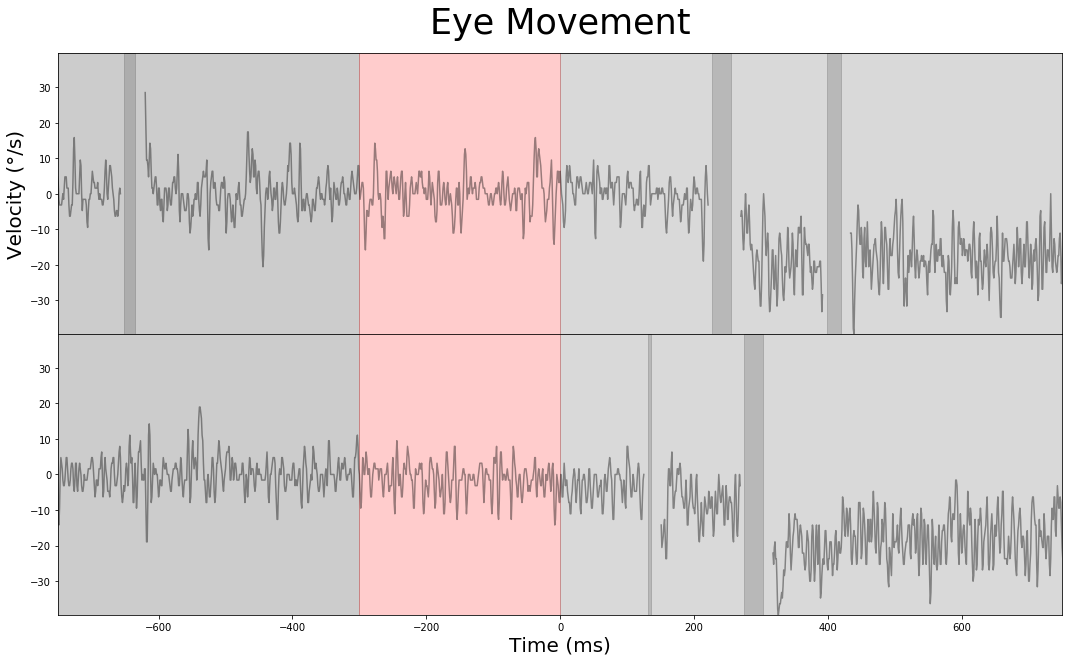

In [5]:
fig, axs = e.plot_velocity(trials=[19, 71])
fig.savefig('figures/raw_trace' + ext, dpi=dpi)

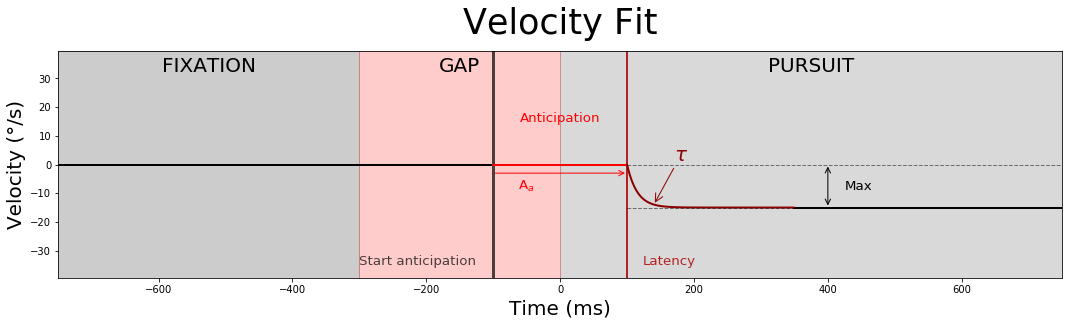

In [7]:
fig, axs= e.plot_Fit()
fig.savefig('figures/raw_fit' + ext, dpi=dpi)

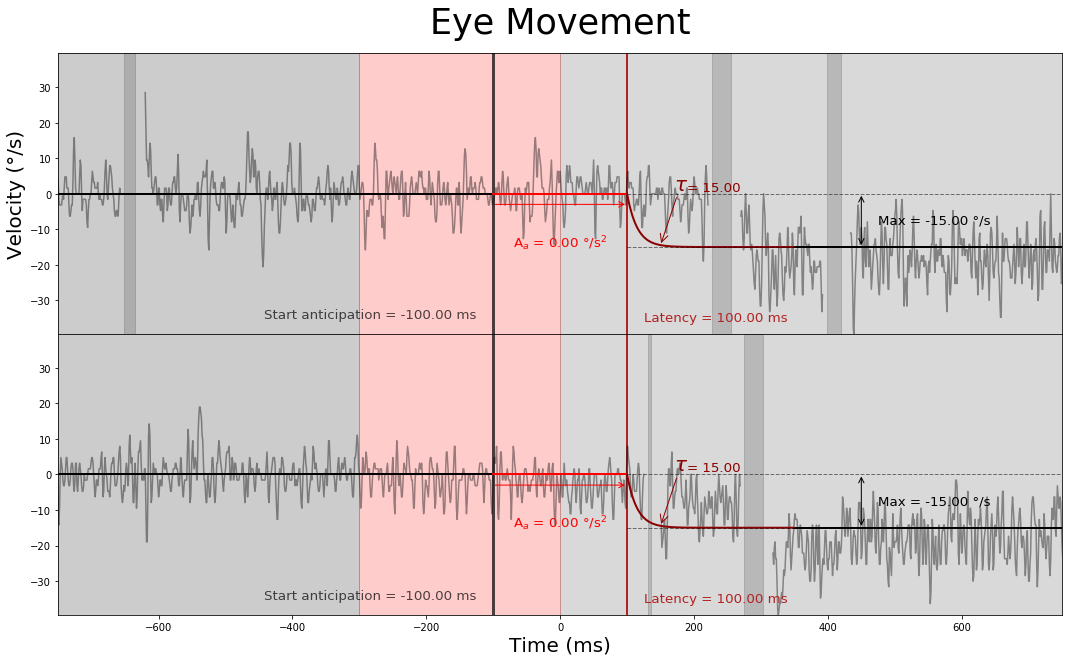

In [8]:
fig, axs = e.plot_Fit(plot='velocity', trials=[19, 71])
fig.savefig('figures/raw_fitted' + ext, dpi=dpi)

/usr/local/lib/python3.6/site-packages/lmfit/printfuncs.py:153: RuntimeWarning: invalid value encountered in double_scalars
  spercent = '({0:.2%})'.format(abs(par.stderr/par.value))


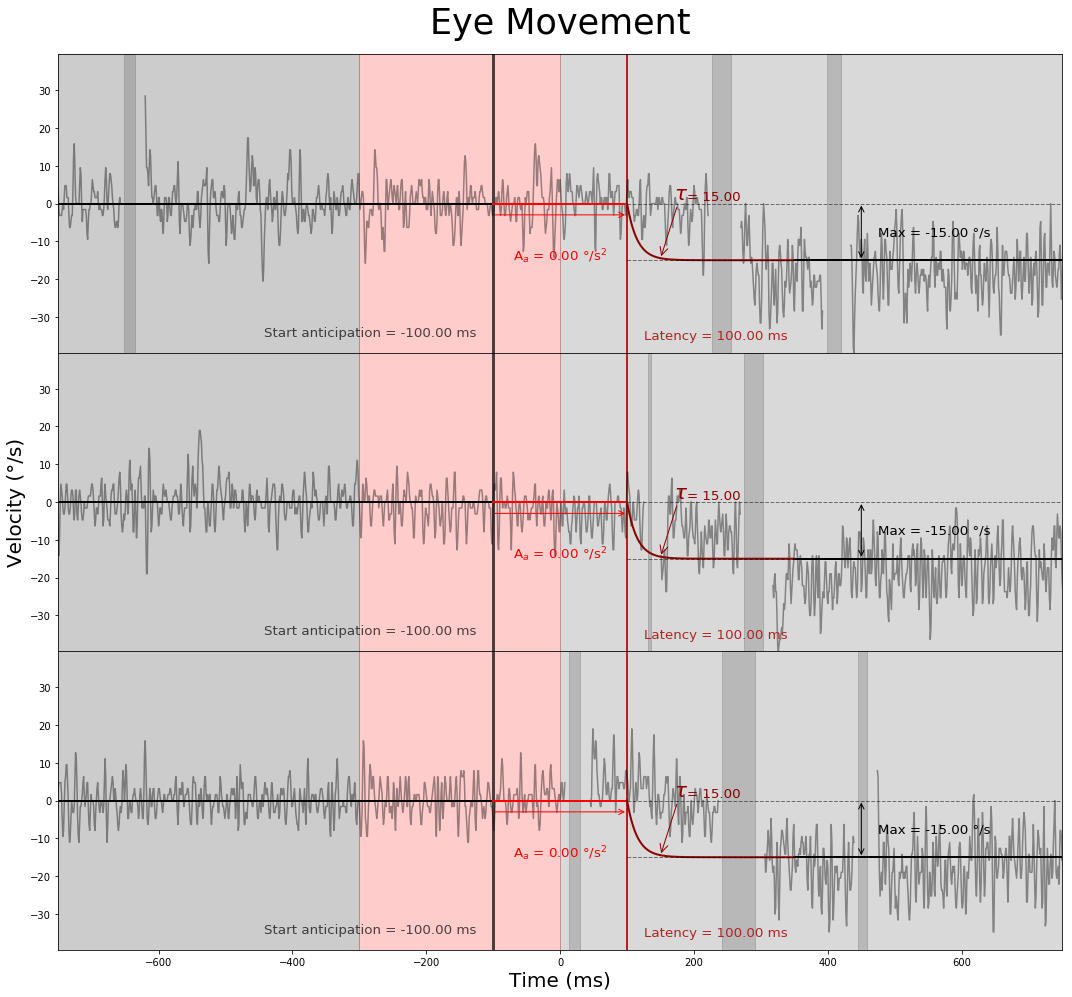

In [9]:
fig, axs, result = e.plot_Fit(plot='velocity', report=True, trials=[19,71,83])

In [10]:
for x in range(len(result)) :
    print('essai',x ,'\n', result[0])

essai 0 
 [[Model]]
    Model(exponentiel)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8
    # data points      = 1705
    # variables        = 5
    chi-square         = nan
    reduced chi-square = nan
    Akaike info crit   = nan
    Bayesian info crit = nan
[[Variables]]
    tau:         15.0000000 +/- 0.00000000 (0.00%) (init = 15)
    maxi:        15.0000000 +/- 0.00000000 (0.00%) (init = 15)
    latence:     916.000000 +/- 0.00000000 (0.00%) (init = 916)
    start_anti:  716.000000 +/- 0.00000000 (0.00%) (init = 716)
    v_anti:      5.9605e-07 +/- 0.00000000 (0.00%) (init = -0)
    bino:        0 (fixed)

essai 1 
 [[Model]]
    Model(exponentiel)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 8
    # data points      = 1705
    # variables        = 5
    chi-square         = nan
    reduced chi-square = nan
    Akaike info crit   = nan
    Bayesian info crit = nan
[[Variables]]
    tau:         15.0000000 +/- 0.000

### Fit

In [11]:
# pour générer les paramètre fit ainsi que les figures de tout les essais
#e.Fit()